In [ ]:
!pip install transformers
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import pandas as pd
import transformers
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("newsdataset.csv", names = ["Category", "Text"])
df.head()

,Category,Text
0,Health,FTSE 100 hits record high
1,Health,Brazil's Jair Bolsonaro admitted to hospital i...
2,Health,"In hospital, I saw first-hand how the NHS has ..."
3,Health,Why Concert Pharmaceuticals Stock Rocketed Hig...
4,Health,Link About It: This Weeks Picks


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,Category,Text
441,Finance,Tanzanian president appoints Emmanuel Tutuba a...
1519,Health,A Review of Major Patents on Potential Malaria...
1991,Tech,Google Concedes Defeat In India? Agrees To Cha...
1193,Tech,Google Pixel 7a hands-on leak reportedly shows...
1711,EVs,Tesla hikes price of Model Y after US alters t...


In [ ]:
df.Category.unique()

array(['Finance', 'Health', 'Tech', 'EVs', 'Telecom'], dtype=object)

In [ ]:
df["Category"] = df["Category"].replace({'Telecom': 0, 'Health': 1, 'EVs': 2, 'Tech': 3, 'Finance': 4})

#Category-wise data point counts
df["Category"].value_counts()

3    658
1    548
2    317
4    297
0    282
Name: Category, dtype: int64

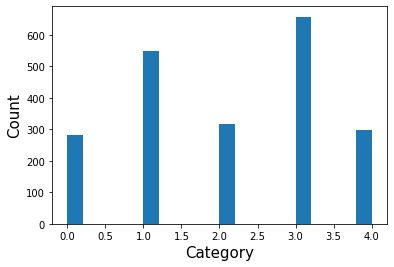

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('Category', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

df.Category.hist(ax=ax,grid=False, bins= 20)
plt.show()


In [ ]:
e_df = df
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(e_df, 
                                   random_state = 0,
                                   test_size = 0.2)

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [ ]:
def convert_data(train, test, DATA_COL, LABEL_COL):
    
    train_input = train.apply(lambda x: InputExample(guid = None,
                                                    text_a = x[DATA_COL],
                                                    text_b = None,
                                                    label = x[LABEL_COL],
                                                    ), axis = 1)
    
    test_input = test.apply(lambda x: InputExample(guid = None,
                                                   text_a = x[DATA_COL],
                                                   text_b = None,
                                                   label = x[LABEL_COL],
                                                   ), axis = 1)
    
    return train_input, test_input

In [ ]:
def convert_to_tf_dataset(input_data, tokenizer, max_length = 200):
    features = []
    
    for i in input_data:
        input_dict = tokenizer.encode_plus(
            str(i.text_a),
            add_special_tokens = True,
            max_length = max_length,
            return_token_type_ids = True,
            return_attention_mask = True,
            pad_to_max_length = True,
            truncation = True
        )
        
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"],
            input_dict["token_type_ids"],
            input_dict["attention_mask"]
        )
        
        features.append(InputFeatures(
            input_ids = input_ids, attention_mask = attention_mask,
            token_type_ids = token_type_ids, label = i.label))
        
    
    def gen():
        for f in features:
            yield({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids
            }, f.label)
            
    
    return tf.data.Dataset.from_generator(
        gen, ({"input_ids": tf.int32, "attention_mask": tf.int32,
              "token_type_ids": tf.int32}, tf.int64),
            ({
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None])
            },
                tf.TensorShape([]), 
            ),)

DATA_COL = "Text"
LABEL_COL = "Category"

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
train, test = convert_data(x_train, x_test, DATA_COL, LABEL_COL)

In [ ]:
train_data = convert_to_tf_dataset(list(train), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

test_data = convert_to_tf_dataset(list(test), tokenizer).batch(32)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name = "accuracy")
]

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = model_metrics)

history = model.fit(train_data, epochs = 5)

Epoch 1/5
106/106 [==============================] - 178s 1s/step - loss: 0.8065 - accuracy: 0.7347
Epoch 2/5
106/106 [==============================] - 126s 1s/step - loss: 0.2491 - accuracy: 0.9286
Epoch 3/5
106/106 [==============================] - 126s 1s/step - loss: 0.0937 - accuracy: 0.9786
Epoch 4/5
106/106 [==============================] - 126s 1s/step - loss: 0.0526 - accuracy: 0.9875
Epoch 5/5
106/106 [==============================] - 126s 1s/step - loss: 0.0362 - accuracy: 0.9899


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = model.predict(test_data)

14/14 [==============================] - 9s 396ms/step


In [ ]:
y_pred_argmax = np.argmax(y_pred[0], axis = 1)

In [ ]:
y_true = x_test["Category"]

Text(33.0, 0.5, 'Ground Truth')

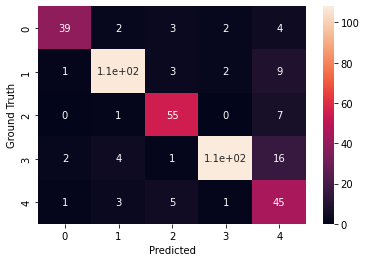

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred_argmax)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot = True)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

In [ ]:
print(classification_report(y_true, y_pred_argmax))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        50
           1       0.91      0.88      0.90       122
           2       0.82      0.87      0.85        63
           3       0.96      0.82      0.89       131
           4       0.56      0.82      0.66        55

    accuracy                           0.84       421
   macro avg       0.83      0.83      0.83       421
weighted avg       0.87      0.84      0.85       421



In [ ]:
model.save('/content/drive/My Drive/Bert/bertnewsmodel')

In [ ]:
recon_model=tf.keras.models.load_model('/content/drive/My Drive/Bert/bertnewsmodel')